In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optimizando la Optimización

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 17/11/2025

> Asignatura: Programación para la Inteligencia Artificial

Cuando empezamos a hablar del ajuste de los parámetros, establecimos que esencialmente el algoritmo de ajuste que usamos es el Descenso del Gradiente Estocástico (*Stochastic Gradient Descent* o SGD) y que en Pytorch lo tenemos como el optimizador **torch.optim.SGD**. A priori, SGD utiliza una regla de ajuste sencilla para los parámetros del modelo.

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \nabla L(m_{\mathbf{w}_{t}}(x))$$

que se descompone para cada parámetro:

$$w_{t+1,i} = w_{t,i} - \gamma\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}}$$

siendo $\mathbf{w}_{t} = (w_{t,1},...,w_{t,n})$ los parámetros del modelo $m$ en el psao de entrenamiento $t$ y $\gamma$ el ratio de aprendizaje. Simplificamos la nomenclatura de la función de pérdida omitiendo la salida conocida.

Siendo más exactos, *a priori* esta es la regla de aprendizaje para el descenso del gradiente si se usan todos los datos para el cálculo de las derivadas parciales. De esa manera obtenemos un único gradiente promediado para actualiuzar el error. Si usamos un solo dato elegido aleatoriamente, hablamos del descenso del gradiente estocástico y, cuando usamos un lote de datos nos podemos referir al método como descenso del gradiente por lotes. Conceptualmente es muy similar, pero como hemos comentado en otros cuadernos, aumentar el números de datos sobre los que calcular el gradiente afecta la cantidad de ruido que tiene dicho gradiente.

Vamos a recapitular algunos conceptos:

Un gradiente calculado con todos los datos tiene el mínimo ruido posible, pero su camino se vuelve determinista (no hay ningún elemento estocástico que incluya variabilidad) y si en ese camino encuentra un mínimo local difícilmente va a poder salir de él. Un gradiente calculado con un solo ejemplo va a tener mucho ruido porque está a merced de lo bien que se ajuste un único ejemplo al modelo. Esto añade un indeterminismo útil para salir de mínimos locales (lo que es un mínimo local para todos los datos en su conjunto, puede no serlo para un único dato), pero hace el entrenamiento más inestable y dificulta la convergencia (además de no aprovechar la paralelización en GPU).

El aprendizaje profundo entrena por lotes, que es un término intermedio, más cerca de uno u otro extremo según el tamaño de los lotes de entrenamiento en relación al total de datos. Aunque en una época recorramos todo el conjunto de datos, el ajuste lo hacemos en cada paso (con cada lote). El gradiente de las ecuaciones es, por tanto, la media de los gradientes para cada dato en el lote.

La cuestión ahora es: ¿podemos mejorar esa manera tan básica de ajustar nuestro modelo para que el entrenamiento sea más rápido, estable y evite caer en mínimos locales? Hay algunas técnicas comunes que vamos a ver, pero antes vamos a recuperar algo de código de otros cuadernos para los ejemplos.

In [2]:
DRIVE=False
if DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'
else:
  workpath = '/workspace/data'

In [3]:
device = 'cuda'
device = torch.device("cuda:0" if (device == 'cuda') and torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class CudaDataset(Dataset):
  def __init__(self, dataset, device, transform = None):
    self.dataset = dataset
    self.cuda_y = []
    self.cuda_x = []
    self.device = device
    self.transform = transform

    for x, y in tqdm(self.dataset, desc="Moving to GPU"):
      self.cuda_x.append(x.to(self.device))
      self.cuda_y.append(torch.tensor(y, device=self.device))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if self.transform is None:
      x = self.cuda_x[idx]
    else:
      x = self.transform(self.cuda_x[idx])
    return x, self.cuda_y[idx]

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

In [5]:
transforms_policy = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root=workpath, train=True, download=True, transform=transforms_policy)
test_dataset = datasets.MNIST(root=workpath, train=False, download=True, transform=transforms_policy)

In [6]:
val_dataset, test_dataset = split_dataset(test_dataset)

In [7]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")

Número de ejemplos en entrenamiento: 60000
Número de ejemplos en validación: 5010
Número de ejemplos en test: 4990


In [8]:
def learning_loop_for_classification(train_dataloader, val_dataloader, model, epochs, loss_fn, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [9]:
def get_test_acc(model, test_dataset, batch_size, device):

  if not str(device)=="cpu":
    test_dataset = CudaDataset(test_dataset, device)

  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  y_pred = []
  y_test = []
  val_step_loss_list = []
  test_correct_answers = 0
  test_set_size = 0

  for test_x_true, test_y_true in test_dataloader:
    y_test.append(test_y_true)
    y_test_pred = model(test_x_true)
    y_pred.append(y_test_pred.detach())

    correct_answers = torch.sum(test_y_true==torch.argmax(y_test_pred, dim=-1))
    test_correct_answers += correct_answers
    test_set_size += test_y_true.numel()

  test_acc = test_correct_answers/float(test_set_size)

  return test_acc

In [10]:
batch_size = 4096
learning_rate = 1e-4
epochs = 200
loss_fn = torch.nn.CrossEntropyLoss()
validation_freq = 5
patience = 50
delta = 0.001

if not str(device)=="cpu":
  val_dataset = CudaDataset(val_dataset, device)
  train_dataset = CudaDataset(train_dataset, device)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

Moving to GPU: 100%|██████████| 60000/60000 [00:07<00:00, 8485.15it/s]


## Optimizar el SGD 

A partir de ahora vamos a dejar fijos todos los parámetros del entrenamiento excepto el optimizador. Definiremos una y otra vez el mismo modelo para que tampoco sea un factor que altere los resultados y estableceremos una semilla para que la inicialización de los pesos del modelo sea siempre la misma.

Vamos a proceder a entrenar con el optimizador SGD en su versión más básica.

In [11]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:54<00:00,  3.70it/s, loss=2.301943302154541] 


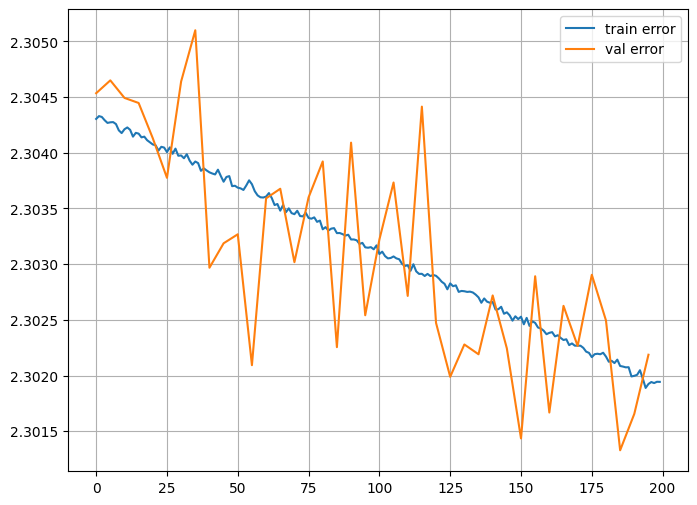

In [12]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(f"Test accuracy: {get_test_acc(model, test_dataset, batch_size, device)}")

Moving to GPU: 100%|██████████| 4990/4990 [00:00<00:00, 8175.26it/s]

Test accuracy: 0.11643286049365997


Como podemos ver el optimizador no está haciendo grandes avances ajustando los pesos de nuestro modelo. Tras 200 épocas, el error de entrenamiento ha bajado muy poco. Esto indica que o los pasos de ajuste que se están produciendo son muy pequeños (que podríamos ajustar alterando el ratio de aprendizaje) o que el gradiente no es muy estable.

El gradiente determina la dirección de actualización de los pesos. Cuando el gradiente es inestable y cambia de forma brusca, el avance en la dirección "correcta" puede ser lento. Para compensarlo existe el *momentum*. La intuición física del *momentum* puede ser el impulso (o la inercia) que lleva un objeto. La idea es que los gradientes pasados afecten a la actualización del momento actual.

Matemáticamente se puede describir como

$$\Delta g_{t} = \mu \Delta g_{t-1} +  \nabla L(m_{\mathbf{w}_{t}}(x))$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \Delta g_{t}$$

Con $\mu$ como el valor de *momentum* que aplicamos y $\Delta g_{t}$ como el incremento (o más bien decremento) que se le aplica al gradiente en el tiempo $t$ (No confundir con el $\Delta$ que usamos en el primer cuaderno para nuestro primitivo método de ajuste). Esencialmente, estamos teniendo en cuenta el vector con el que incrementamos (o más bien decrementamos) el gradiente en el paso anterior para añadir una parte de ese incremento (regulado por $\mu$) también a este paso. $\mu$ suele tener valores entre 0.9 y 0.99 cuando se aplica, lo que es darle mucha importancia a los pasos anteriores para actualizar el gradiente. El *momentum* va a tener como efecto directo que los pasos de ajuste sean más grandes y que crezcan si la dirección de actualización se mantiene. Se puede imaginar como una pelota rodando por una colina irregular. Cuanto más rueda en una dirección, más rápido rueda en esa dirección.

Además de poder ayudar a acelerar la convergencia, el *momentum* ayuda a evitar mínimos locales porque aunque se llegue a un puntoen el que el gradiente sea muy bajo (o incluso 0), el factor acumulado de los gradientes anteriores va a provocar la actualización de los pesos. Esto se puede imaginar como si en la colina por la que tiramos nuestra pelota hubiera pequeños agujeros. Si la pelota fuera despacio, una vez dentro de esos agujeros no podría salir, pero al llevar impulso por la caída es capaz de superar una pendiente de subida pequeña.

[Más información](https://distill.pub/2017/momentum/)

En el SGD el *momentum* se puede establecer símplemente indicándolo en el argumento correspondiente ([link a la API](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html)).

In [14]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:54<00:00,  3.70it/s, loss=2.277034282684326] 


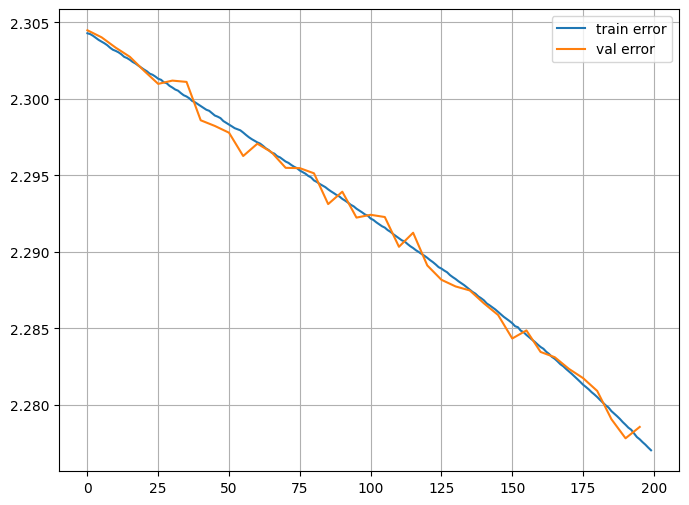

In [15]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f"Test accuracy: {get_test_acc(model, test_dataset, batch_size, device)}")

Moving to GPU: 100%|██████████| 4990/4990 [00:00<00:00, 8386.79it/s]


Test accuracy: 0.2551102042198181


Como podemos observar, el error disminuye más rápido como esperábamos. Aumentar el *momentum* puede acelerar aún más la convergencia.

In [17]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.99
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:54<00:00,  3.67it/s, loss=0.40765658020973206]


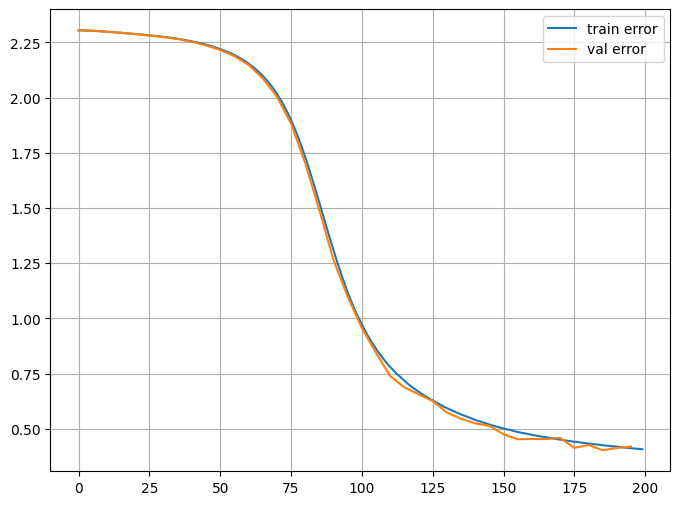

In [18]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(f"Test accuracy: {get_test_acc(model, test_dataset, batch_size, device)}")

Moving to GPU: 100%|██████████| 4990/4990 [00:00<00:00, 8513.85it/s]


Test accuracy: 0.8825651407241821


Hay un segundo factor, el *dampening* ($\tau$) que permite modular la influencia del gradiente actual respecto al acumulado del *momentum*.

$$\Delta g_{t} = \mu \Delta g_{t-1} +  (1-\tau) \nabla L(m_{\mathbf{w}_{t}}(x))$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \Delta g_{t}$$

Sin embargo, no es un factor que suela usarse con tanta frecuencia.

Si uno observa la información del SGD en Pytorch, observa que hay algunos argumentos más configurables. Uno muy interesante es el *weight decay* o disminución del peso (controlado con el factor $\lambda$). La disminución de los pesos se añade a la función matemática como sigue:

$$\Delta g_{t} = \mu \Delta g_{t-1} +  (1-\tau) (\nabla L(m_{\mathbf{w}_{t}}(x))+\lambda \mathbf{w}_{t})$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \Delta g_{t}$$

Este factor tiene un objetivo: que los pesos del modelo sean lo más bajos posibles. Supongamos que no aplicamos *momentum* ni *dampening* ($\mu=0$ y $\tau=0$) y que el gradiente fuera nulo ($\nabla L(m_{\mathbf{w}_{t}}(x))=0$) para ver más claro qué hace ese elemento de la ecuación:

$$\Delta g_{t} = \lambda \mathbf{w}_{t}$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \Delta g_{t}$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \lambda \mathbf{w}_{t}$$

La actualización de los pesos va a acercar los pesos a 0 (en un caso extremo, con $\gamma=1$ y $\lambda=1$, los pesos pasarían a 0 en un solo paso de actualización en este caso).

¿Por qué es interesante mantener los pesos con valores bajos? En teoría, contribuye a la generalización disminuyendo el sobreajuste. La intuición tras esto es que unos pesos muy grandes provocan que los cambios en las entradas del modelo tengan un efecto mucho mayor (recordemos que los pesos multiplican las entradas), mientras que unos pesos pequeños minimiza el efecto de los cambios de la entrada. Dos entradas parecidas (cambios pequeños en la entrada) queremos normalmente que provoquen un comportamiento similar en el modelo.

Esto es una espada de doble filo. Una disminución del peso demasiado grande provoca el *underfitting* (infraajuste): impide que el modelo aprenda.

Este concepto de imponer restricciones condicionando cómo debe ajustarse el modelo es lo que llamamos regularización.


In [ ]:
epochs = 4000
batch_size = 8192

In [21]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.99,
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 4000/4000 [18:01<00:00,  3.70it/s, loss=0.013637124560773373]


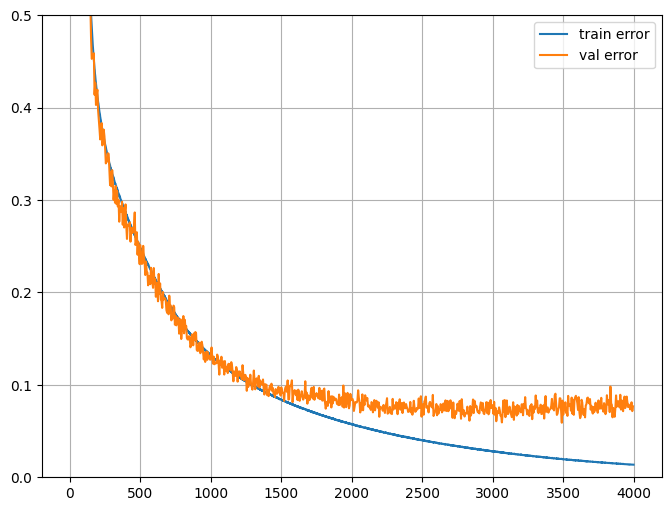

In [22]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.ylim(0,0.5)
plt.grid(True)
plt.show()

In [23]:
print(f"Media de valores para los pesos {torch.tensor([p.mean() for p in model.parameters()]).abs().mean()}")

Media de valores para los pesos 0.011904668062925339


In [24]:
print(f"Test accuracy: {get_test_acc(model, test_dataset, batch_size, device)}")

Moving to GPU: 100%|██████████| 4990/4990 [00:00<00:00, 8626.01it/s]


Test accuracy: 0.9715430736541748


In [25]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.99,
    weight_decay=1e-3
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 4000/4000 [18:14<00:00,  3.66it/s, loss=0.034082964062690735]


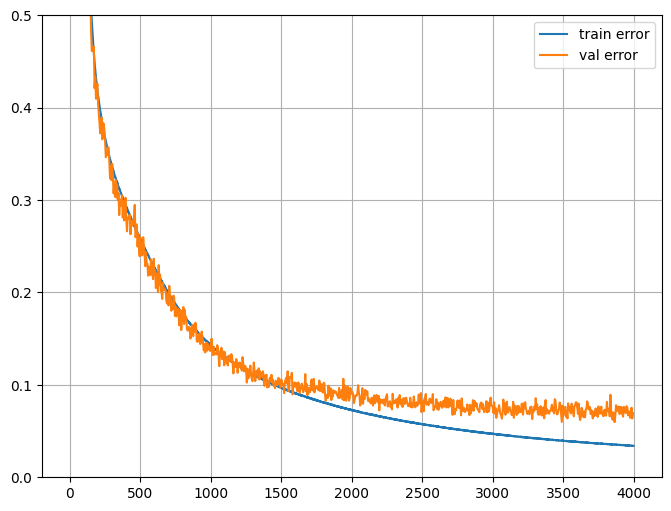

In [26]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.ylim(0,0.5)
plt.grid(True)
plt.show()

In [27]:
print(f"Media de valores para los pesos {torch.tensor([p.mean() for p in model.parameters()]).abs().mean()}")

Media de valores para los pesos 0.009648917242884636


In [28]:
print(f"Test accuracy: {get_test_acc(model, test_dataset, batch_size, device)}")

Moving to GPU: 100%|██████████| 4990/4990 [00:00<00:00, 8393.59it/s]


Test accuracy: 0.9721442461013794


Como podemos ver, en el segundo entrenamiento la gráfica de validación se aleja más despacio de la de entrenamiento según avanzan las épocas.

El último elemento que podemos ver si inspeccionamos el SGD en la API de Pytorch es la Aceleración de Nesterov. Este concepto es una alterntiva conceptualmente relacionada con el *momentum*.

$$\Delta g_{t} = \mu \Delta g_{t-1} + \gamma \nabla L(m_{\mathbf{w}_{t}-\mu \Delta g_{t-1} }(x))$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \Delta g_{t}$$

La propuesta es, durante la actualización de los pesos calcular el gradiente en la posición adelantada donde nos dejará el *momentum* ($\mu \Delta g_{t-1}$) y corregir la actualización usando ese gradiente "futuro". Esto teóricamente facilita la convergencia al permitir "corregir" antes una dirección errónea.

PyTorch no implementa esta formula tal cuál, sino una reordenación algebraica del cálculo para hacerlo más eficiente, pero teóricamente equivalente.

$$\Delta g_{t} = \nabla L(m_{\mathbf{w}_{t}}(x)) + \mu(\mu \Delta g_{t-1} + \nabla L(m_{\mathbf{w}_{t}}(x)))$$

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \gamma \Delta g_{t}$$


La verdad es que la aceleración de Nestorov se usa poco.

## Alterar el Ratio de Aprendizaje

Otra técnica que vale la pena comentar ahora es la manipulación del ratio de aprendizaje durante el entrenamiento (normalmente para ir reduciéndolo). La intuición es sencilla: según avanza el entrenamiento, nos puede interesar que nuestros pasos de actualización de pesos sean más pequeños porque deberíamos estar más cerca de la solución. Los pasos grandes pueden ser demasiado grandes y "pasar la solución de largo" en lugar de acercarse a ella de manera consistente y estable. La idea suele ser avanzar más despacio cuanto más avanzamos.

Estas técnicas en PyTorch (Y en Tensorflow) están desligadas de los optimizadores y se gestionan con unas clases que heredan de **torch.optim.LRScheduler**. Un *scheduler* (planificador) es una clase que gestiona el avance del ratio de aprendizaje. Como es una clase nueva, necesitmaos introducirlo en nuestro bucle de entrenamiento para usarlo. Para ello simplemente contemplamos el paso del *scheduler* en cada época.

In [29]:
def learning_loop_for_classification_with_scheduler(train_dataloader, val_dataloader, model, epochs, loss_fn, optimizer, scheduler, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))
    scheduler.step()

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [30]:
from torch.optim.lr_scheduler import StepLR

Para inicializar un *scheduler* solo hay que indicarle qué de qué optimizador debe ocuparse.

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.99,
  )

scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification_with_scheduler(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    scheduler,
    validation_freq = validation_freq)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

Distintos *scheduler* permiten definir distintas políticas para la actualización. El más sencillo probablemente sea **StepLR** que cada *step_size* pasos multiplica el ratio de aprendizaje por *gamma*. Vamos a verlo rápidamente:

In [32]:
learning_rate = 0.05

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
  )

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

list_of_lr = []

for i in range(100):
    optimizer.step()
    scheduler.step()
    list_of_lr.append(scheduler.get_last_lr())

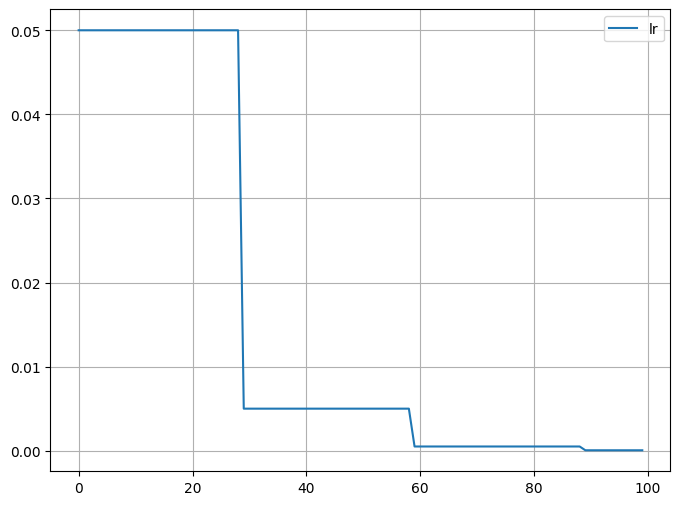

In [33]:
plt.figure(figsize=(8,6))
plt.plot(range(0, 100), list_of_lr, label="lr")
plt.legend()
plt.grid(True)
plt.show()

Hay diversos planificadores más complejos, pero manipular el ratio de aprendizaje de esta manera tiene dos problemas generales:
 * Requiere que a base de observar cómo evoluciona el entrenamiento ajustemos una planificación conveniente.
 * El ratio de aprendizaje es general para todos los componentes del gradiente. ¿Y si es conveniente darle más peso a uno que a otros?

En definitiva: se adapta poco a lo que está ocurriendo realmente con los gradientes durante el entrenamiento.


## Alternativas al SGD

### Adagrad

La idea tras el AdaGrad (*Adaptative Gradient*) es adaptarse al gradiente de cada peso. Para el $i$-ésimo peso plantea la siguiente regla de actualización en el paso $t$:

$$v_{t,i}=v_{t-1,i} + (\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}})^2$$

$$w_{t+1,i} = w_{t,i}-\frac{\gamma}{\sqrt{v_{t}}+\epsilon}\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}}$$

Aunque la matemática pueda parecer un poco compleja, la idea es sencilla: que cada peso tenga un ratio de aprendizaje en relación al tamaño de los gradientes anteriores. El cuadrado al calcular $v_{t,i}$ y la posterior raiz cuadrada es solo para asegurar que el valor sea positivo. A más pequeños sean los gradientes de un peso, mayor va a ser su ratio de aprendizaje. A más grande, menor. Esto puede ir en contra de la intuición. Si un gradiente es mayor, será que hay una inclinación mayor respecto a la pérdida y, por tanto, hace falta que el peso se actualice más, ¿no? A veces sí, a veces no. 

Imaginemos un peso que tiene muy poca relevancia la mayoría del tiempo (con lo que su gradiente es muy pequeño), pero hay algunos ejemplos (pocos) para los que es crítico (su gradiente es muy grande). Si ese peso solo se actualiza de manera relevante con esos ejemplos en los que es crítico, su avance hacia el mínimo es muy despacio la mayoría del tiempo con grandes saltos puntuales. Es muy inestable. Si le damos más importancia a ese gradiente del que debería tener cuando es poco relevante, conseguimos que su avance sea más constante. Por el contrario, si a la vez hay algún peso que es crítico casi siempre (su gradiente es muy grande), ralentizamos su aprendizaje para intentar nivelarlo con los pesos más "lentos".

AdaGrad típicamente funciona bien con conjuntos de datos conocidos como *sparse* o dispersos. Conjuntos de datos en los que muchas de las características no son relevantes la mayoría del tiempo, pero puntualmente tienen mucha relevancia.

Esto por sí mismo no evita los mínimos locales, pero se puede combinar con el *momentum*.

Problema: el crecimiento de $v_{t,i}$ es monótono. Siempre va a más, así que inevitablemente con el tiempo el ratio de aprendizaje de todos los pesos va a ir disminuyendo. AdaGrad va ralentizando el aprendizaje con el paso de las épocas y puede llegar a ser contraproducente.

Lo importante del AdaGrad es la idea de adaptar los ratios de aprendizaje.

In [51]:
learning_rate = 1e-3
epochs = 200
batch_size = 1024

In [52]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

epoch: 100%|██████████| 200/200 [00:56<00:00,  3.56it/s, loss=0.16869229078292847]


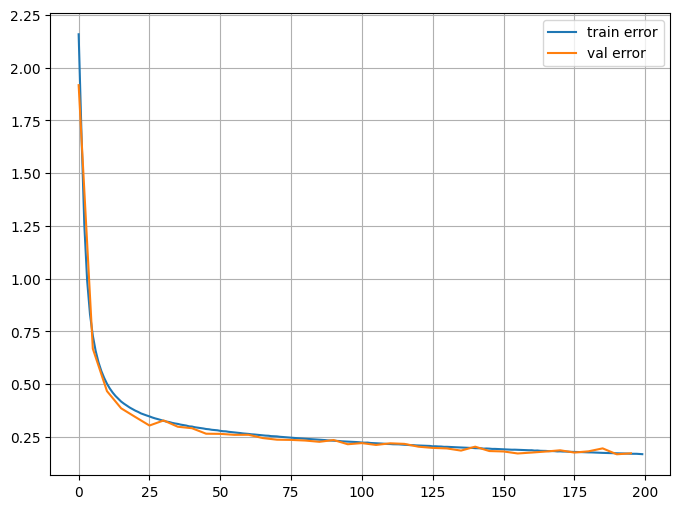

In [53]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

### RMSProp

RMSProp (*Root Mean Square Propagation*) sigue una idea parecida a la de AdaGrad, pero en lugar de ir acumulando los cuadrados sin más, los promedia.

$$v_{t,i}=\beta v_{t-1,i} + (1-\beta)(\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}})^2$$

$$w_{t+1,i} = w_{t,i}-\frac{\gamma}{\sqrt{v_{t}}+\epsilon}\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}}$$

Simplemente añadiendo ese factor $\beta$ permite "olvidar" los gradientes pasados, con lo que el factor $v_{t,i}$ ya no tiene por qué crecer siempre. Soluciona el problema del AdaGrad.

In [54]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

epoch: 100%|██████████| 200/200 [00:56<00:00,  3.56it/s, loss=0.00017079667304642498]


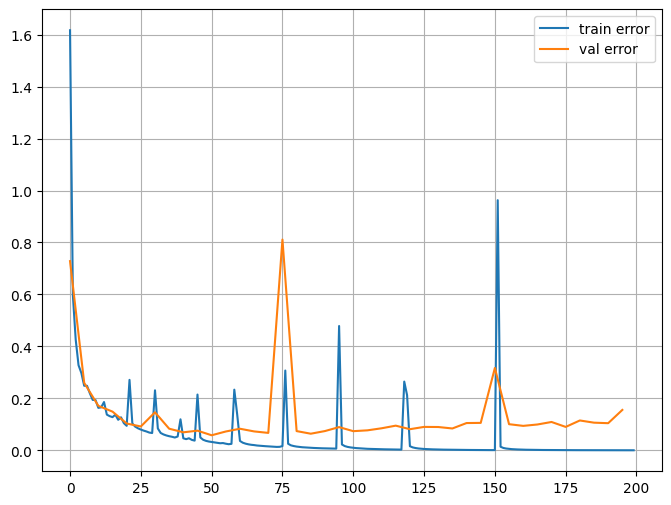

In [55]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

### Adam

Probablemente el optimizador más usado. Adam (*Adaptative Moment Estimation*) combina las ideas de los optimizadores anteriores con el *momentum* y una corrección del sesgo. Aunque típicamente en la literatura del Adam se habla de *momentum* de primer orden ($\beta_{1}$) y *momentum* de segundo orden ($\beta_{2}$). El *momentum* de primer orden es el concepto de *momentum* que hemos visto anteriormente y el de segundo orden, la adaptación automática del ratio de aprendizaje que hemos visto en RMSProp. Por ser consistentes, para el *momentum* de primer orden usaremos la $\mu$ y la $\beta$ para el otro.

$$m_{t,i} = \mu m_{t-1,i} + (1-\mu)\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}}$$

$$\widehat{m_{t,i}} = \frac{m_{t,i}}{1-\mu^t}$$

$$v_{t,i}=\beta v_{t-1,i} + (1-\beta)(\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}})^2$$

$$\widehat{v_{t,i}} = \frac{v_{t,i}}{1-\beta^t}$$

$$w_{t+1,i} = w_{t,i}-\frac{\gamma\widehat{m_{t,i}}}{\sqrt{\widehat{v_{t}}}+\epsilon}$$




Esencialmente estamos mezclando los dos elementos, pero hemos añadido unas operaciones que tienen como objetivo corregir el sesgo inicial de los componentes $m_{t,i}$ y $v_{t,i}$. Su utilidad es fácil de ver. En todos estos algoritmos esos valores que "acumulamos" comienzan a 0. Con t=1, $m_{t-1,i}=0$ y $v_{t-1,i}=0$. Si nos planteamos esa primera iteración y tenemos un valor de $\mu$ alto (el artículo original recomienda $\mu=0.9$), nuestro $m_{1,i}=0+0.1\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}}$. Lo mismo para un valor $\beta$ alto (en el artículo original recomiendan $\beta=0.999$), $v_{1,i}=0 + 0.001(\frac{\partial L(m_{\mathbf{w}_{t}}(x))}{\partial w_{t,i}})^2$. Los valores al principio del entrenamiento de $m_{t,i}$ y $v_{t,i}$ serán muy bajos para todos los pesos. Para compensarlo se incluye esa corrección. Los denominadores serán muy bajos en los primeras iteraciones para aumentar el valor de $\widehat{m_{t,i}}$ y $\widehat{v_{t,i}}$, pero al avanzar $t$ pasarán a ser irrelevantes.

¡Vamos a verlo en acción con sus parámetros por defecto!

In [56]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:56<00:00,  3.57it/s, loss=0.00011802402877947316]


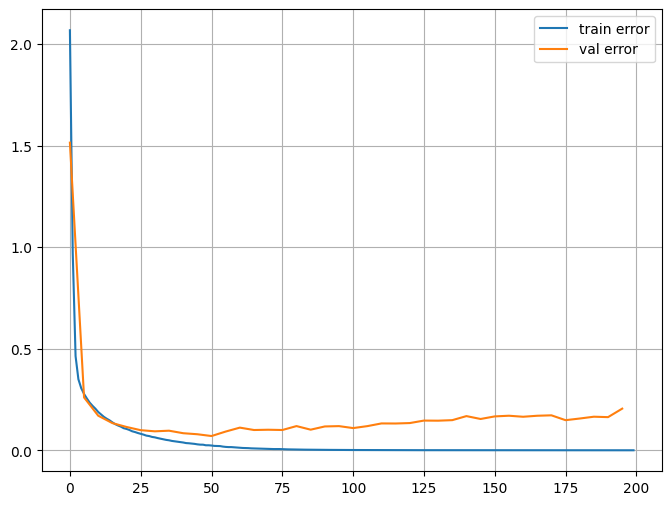

In [57]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
#plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [a.cpu() for a in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

# Conclusiones

Aunque la idea de utilizar el gradiente para ajustar los pesos de las redes neuronales es general, existen diversos criterios de ajuste posibles. Lo ideal sería conocer el camino perfecto para llegar al mínimo absoluto esquivando mínimos locales, pero como solo podemos hacer suposiciones, hay diversas maneras de intentar que ese camino sea lo más estable y directo posible.

Tanto el *momentum* como el ajuste de la tasa de aprendizaje de manera adaptativa para cada peso son dos criterios bastante efectivos que combinados dan lugar al optimizador Adam.

